### Importación de las librerias necesarias

In [ ]:
import time
import datetime
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_absolute_error

### Propiedades del lienzo y normalización de los datos

In [ ]:
plt.style.use('fivethirtyeight')
#Ajustando tamaño del gráfico
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#Normalización de la data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

### Cargamos la data que utilizaremos, la de Microsoft (MSFT)

In [ ]:
ticker='MSFT'
#Estableciendo el periodo 2015
period1 = int(time.mktime(datetime.datetime(2015, 1, 1, 0, 0).timetuple()))
period2 = int(time.mktime(datetime.datetime.now().timetuple()))
interval = '1d' # 1d, 1m
query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'
df_dis = pd.read_csv(query_string)

In [ ]:
#Creando el dataframe original
data = df_dis.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df_dis)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#Estableciendo el index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#Creando sets de testeo
dataset = new_data.values

train = dataset[0:1551,:]
valid = dataset[1551:,:]

#Conversión del dataset a las variables de entrenamiento x_train y y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [ ]:
#Creación del modelo LSTM
from tensorflow.keras.models import Sequential
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

#Compilación del modelo, tomando el cuenta el error de tipo cuadrático y optimizador adam
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#Generando predicción de valores segun lo indicado:
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

#Haciendo la población de datos del testeo
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

1491/1491 - 39s - loss: 5.6409e-04 - 39s/epoch - 26ms/step
12/12 [==============================] - 1s 17ms/step


In [ ]:
X_test.shape

(369, 60, 1)

In [ ]:
closing_price.shape

AttributeError: ignored

In [ ]:
#Calculando indicador de precisión del modelo (a menor valor -> más preciso)
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

10.046097747468481

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


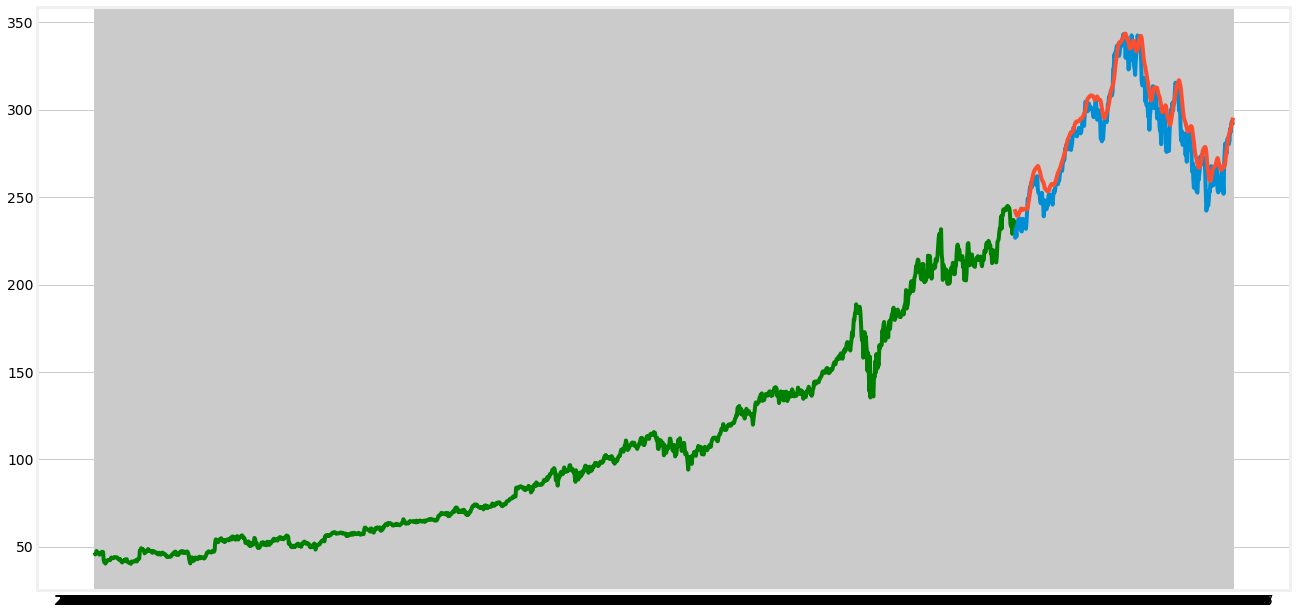

In [ ]:
#Representación en gráfico, tiempo vs. valor de cierre
train = new_data[:1551]
valid = new_data[1551:]
valid['Predictions'] = closing_price

plt.figure(facecolor="white")
ax = plt.axes()
ax.set_facecolor("white")

plt.plot(train['Close'],color="green")
plt.plot(valid[['Close','Predictions']])


In [ ]:
valid[['Close','Predictions']

In [ ]:
valid

,Close,Predictions
Date,,
2021-03-03,227.559998,243.114227
2021-03-04,226.729996,242.058228
2021-03-05,231.600006,240.771179
2021-03-08,227.389999,240.128250
2021-03-09,233.779999,239.303101
...,...,...
2022-08-11,287.019989,289.159698
2022-08-12,291.910004,290.466461
2022-08-15,293.470001,292.152344
